## YOLOv7 based yoga pose classification

### Step 1:  Download YOLOv7 repository from Github and install all requirements

In [1]:
!git clone https://github.com/WongKinYiu/yolov7

Cloning into 'yolov7'...
remote: Enumerating objects: 734, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (89/89), done.
remote: Total 734 (delta 240), reused 213 (delta 209), pack-reused 436
Receiving objects: 100% (734/734), 67.50 MiB | 5.60 MiB/s, done.
Resolving deltas: 100% (361/361), done.


In [7]:
import os
os.getcwd()

'/Users/paultsoi/Desktop/Machine_Learning_Jupyter/YOLOv5'

In [1]:
#! pip install -r ./yolov7/requirements.txt

### Step 2: Start prediction based on pre-loaded yoga pose images

* !python: Loading detect.py file in the yolov7 folder
* weight: The weight after trained with custom dataset 
* img: Input image size 
* conf: Confidence threshold 
* source: Pre-loaded images or videos (0: webcam; img.jpg: image; vid.mp4: video; path/*.jpg: glob)

#### Return
* Classified labels
* Path for the detected images with binding boxes

In [123]:
predicted = !python ./yolov7/detect.py --weights ./yolov7/best.pt --img 640 --conf 0.1 --source ./datasets/yolo_yoga-3/test/images/000201_jpg.rf.0d82da0cd79710b5c1b4301180af4c09.jpg


### Step 3: Extract labels, path after the detection, and plot the result

In [126]:
import os
label_pred = predicted[-2]
path = os.path.join('./', predicted[-1])
print('classified pose: ', label_pred)

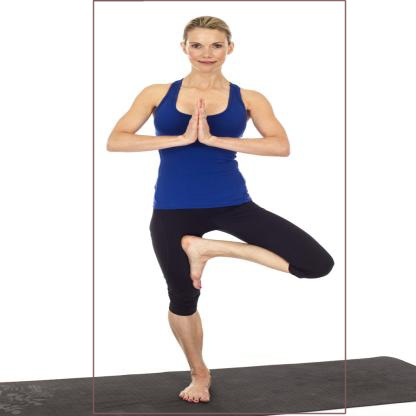

tree




In [127]:
import glob
from IPython.display import Image, display

for imageName in glob.glob(path): #assuming JPG
    display(Image(filename=imageName))
    print("\n")

### Step 4: Define Movenet for pose estimation to evaluate yoga pose  

In [114]:
# Define Movenet for pose estimation
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2

Edges = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

# Draw all keypoints/landmarks 
def draw_keypoints(frame, keypoints):
    y, x, z = frame.shape
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))

    for kps in shaped:
        kps_y, kps_x, _ = kps
        cv2.circle(frame, (int(kps_x), int(kps_y)), 4, (0,255,0), -1)
    return None

# Plotting the skeleton after collecting all keypoints 
def plot_skeleton(frame, keypoints, edge):
    y, x, c = frame.shape 
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    for edge, _ in edge.items():
        kp_1, kp_2 = edge
        y1, x1, c1 = shaped[kp_1]
        y2, x2, c2 = shaped[kp_2]
        
        cv2.line(frame, (int(x1), int(y1)), (int(x2), int(y2)), (255,0,0), 2)
    return None


#### Define function to calculate joint angles and set criteria for pose evaluation 

In [157]:
# Calculate joint angle for evaluation
def get_angle(keypoint_1, keypoint_2, keypoint_3):
    a = keypoint_1[0:2]
    b = keypoint_2[0:2]
    c = keypoint_3[0:2]
    
    ba = a-b
    bc = c-b
    
    cosine_angle = np.dot(ba,bc)/(np.linalg.norm(ba)*np.linalg.norm(bc))
    
    angle = np.degrees(np.arccos(cosine_angle))
    
    return angle

def tree_evaluate(angle):
    right_foot_angle = get_angle(angle['right_hip'], angle['right_knee'], angle['right_ankle'])
    left_foot_angle = get_angle(angle['left_hip'], angle['left_knee'], angle['left_ankle'])

    if (right_foot_angle < 45 and left_foot_angle > 170) or (left_foot_angle < 45 and right_foot_angle > 170):
        print('good posture, keep it up')
    else:
        print('raise your foot')

def godness_evaluate(angle):
    right_foot_angle = get_angle(angle['right_hip'], angle['right_knee'], angle['right_ankle'])
    left_foot_angle = get_angle(angle['left_hip'], angle['left_knee'], angle['left_ankle'])
    
    if 110< right_foot_angle < 140 and 110 < left_foot_angle < 140:
        print('good posture, keep it up')
        
    elif right_foot_angle > 140 or left_foot_angle > 140: 
        print('Please bend your elbow')
        
    elif right_foot_angle < 110 and left_foot_angle < 110: 
        print('Your elbow bend too much')


def pose_evaluation(frame, keypoints, label):
    y, x, c = frame.shape 
    shaped = np.squeeze(np.multiply(keypoints, [y,x,1]))
    
    right_hip = shaped[12] 
    right_knee = shaped[14] 
    right_ankle = shaped[16] 
    left_hip = shaped[11] 
    left_knee = shaped[13]   
    left_ankle = shaped[15]
    
    angle_dict = {'right_hip': right_hip, 'right_knee': right_knee, 'right_ankle': right_ankle,
                  'left_hip': left_hip, 'left_knee': left_knee, 'left_ankle': left_ankle
                 }
    
    if label =='tree':
        tree_evaluate(angle_dict)
    
    elif label == 'godness':
        godness_evaluate(angle_dict)
    

#### Main Function

In [169]:
def movenet(images, label):
    interpreter = tf.lite.Interpreter(model_path='./lite-model_movenet_singlepose_lightning_tflite_float16_4.tflite')
    interpreter.allocate_tensors()
    
    
    cap = cv2.VideoCapture(str(images))
    ret, frame = cap.read()
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    img = frame.copy()
    img = np.expand_dims(img, axis=0)
    img = tf.image.resize_with_pad(img, 192, 192)
    input_image = tf.cast(img, dtype=np.uint8)
    
    # Input and output
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    interpreter.set_tensor(input_details[0]['index'], np.array(input_image))
    interpreter.invoke()
    keypoints_with_scores = interpreter.get_tensor(output_details[0]['index'])
    
    plot_skeleton(frame, keypoints_with_scores, Edges)
    draw_keypoints(frame, keypoints_with_scores)
    pose_evaluation(frame, keypoints_with_scores, label)
    plt.figure(figsize = (8,8))
    plt.imshow(frame)
    plt.show()
    print("\n")
    return frame, keypoints_with_scores

### Plot the result with binding box and skeleton, supplemented with yoga pose evaluation

#### For good posture example (tree pose)

In [116]:
predicted = !python ./yolov7/detect.py --weights ./yolov7/best.pt --img 640 --conf 0.1 --source ./datasets/yolo_yoga-3/test/images/00000088_jpg.rf.b0cdf14c92955ee7839bc46292560524.jpg


In [133]:
import os
label_pred = predicted[-2]
path = os.path.join('./', predicted[-1])
print('classified pose: ', label_pred)

classified pose:  tree


good posture, keep it up


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


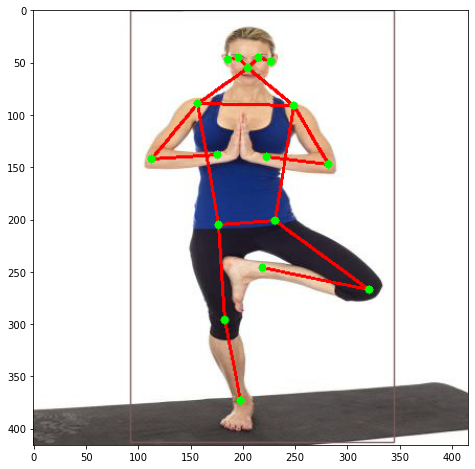

In [140]:
for imageName in glob.glob(path): #assuming JPG
    frame, keypoints_with_scores = movenet(imageName, label_pred)
    print("\n")

#### For bad posture example (tree pose)

In [166]:
predicted = !python ./yolov7/detect.py --weights ./yolov7/best.pt --img 640 --conf 0.1 --source ./datasets/yolo_yoga-3/test/images/000113_jpg.rf.8306b333ff631cecf217ab95f67d271c.jpg

In [167]:
import os
label_pred = predicted[-2]
path = os.path.join('./', predicted[-1])
print('classified pose: ', label_pred)

classified pose:  tree


raise your foot


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


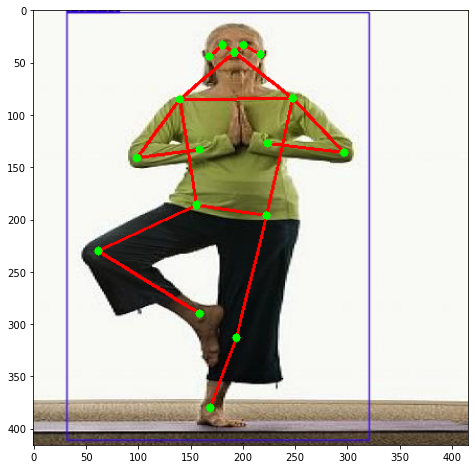

In [168]:
for imageName in glob.glob(path): #assuming JPG
    frame, keypoints_with_scores = movenet(imageName, label_pred)
    print("\n")

#### For good posture example (godness pose)

In [149]:
predicted = !python ./yolov7/detect.py --weights ./yolov7/best.pt --img 640 --conf 0.1 --source ./datasets/yolo_yoga-3/test/images/00000178_jpg.rf.a150082c6c5123b317beff715ba7bb35.jpg

In [150]:
import os
label_pred = predicted[-2]
path = os.path.join('./', predicted[-1])
print('classified pose: ', label_pred)

classified pose:  godness


good posture, keep it up


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


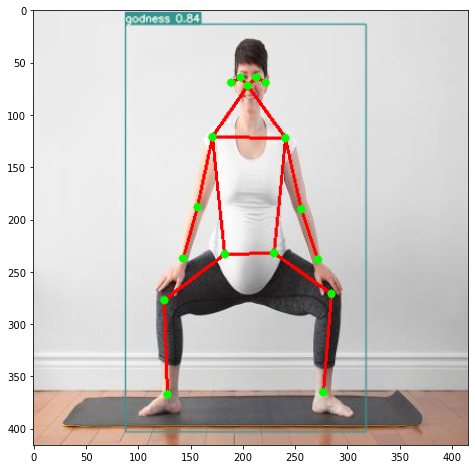

In [159]:
for imageName in glob.glob(path): #assuming JPG
    frame, keypoints_with_scores = movenet(imageName, label_pred)
    print("\n")

### For bad posture example (godness pose)

In [160]:
predicted = !python ./yolov7/detect.py --weights ./yolov7/best.pt --img 640 --conf 0.1 --source ./datasets/yolo_yoga-3/test/images/00000132_jpg.rf.0802034a8ef41812269769a39cda715c.jpg

In [161]:
import os
label_pred = predicted[-2]
path = os.path.join('./', predicted[-1])
print('classified pose: ', label_pred)

classified pose:  godness


Please bend your elbow


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


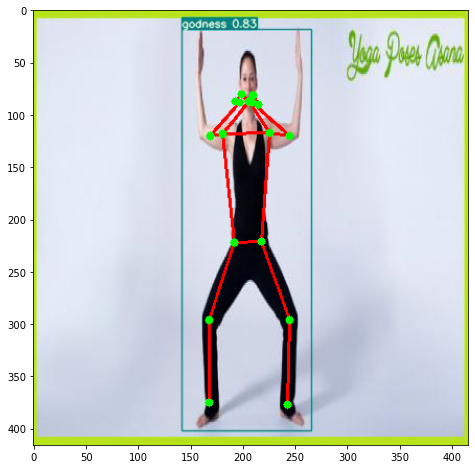

In [162]:
for imageName in glob.glob(path): #assuming JPG
    frame, keypoints_with_scores = movenet(imageName, label_pred)
    print("\n")

In [163]:
predicted = !python ./yolov7/detect.py --weights ./yolov7/best.pt --img 640 --conf 0.1 --source ./datasets/yolo_yoga-3/test/images/1.jpg

In [164]:
import os
label_pred = predicted[-2]
path = os.path.join('./', predicted[-1])
print('classified pose: ', label_pred)

classified pose:  godness


INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


Your elbow bend too much


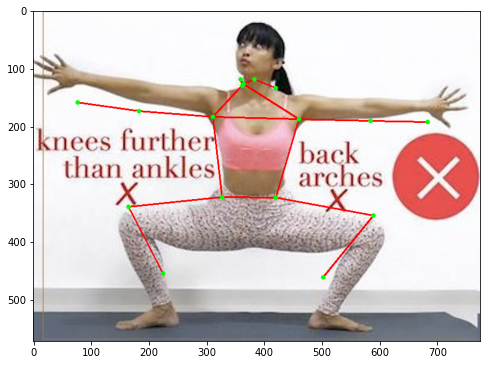

In [165]:
for imageName in glob.glob(path): #assuming JPG
    frame, keypoints_with_scores = movenet(imageName, label_pred)
    print("\n")